# **Image classification**
Machine learning project for image classification using different types of models. I used 'MedMNIST-Pneumonia' data set for training.
The aim of this project is to train and evaluate one or more classification models in order to establish if the lungs in the images are affected by pneumonia or not.

In [182]:
!pip install keras_tuner

Cell that groups all the libraries used for this project

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

from IPython.display import Markdown, display
import seaborn as sns
from glob import glob
from PIL import Image
import os
import cv2

import tensorflow as tf
from tensorflow import keras
import keras_tuner
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [184]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

I loaded the dataset. The images are stored in the file 'pneumonia_images' and the labels in 'pneumonia_labels'.

In [185]:
# Uploading dataset MedMNIST
try:
    X = np.load("/content/drive/MyDrive/pneumonia_images.npy")
    y = np.load("/content/drive/MyDrive/pneumonia_labels.npy")
except FileNotFoundError:
    print("File not found. Make sure you have the correct path")
    exit()

This code snippet counts the number of normal and pneumonia images, displays a sample of each class, and shows the class distribution.

Image shape: (28, 28)
Total normal images: 1349
Total pneumonia images: 3883
Total images: 5232


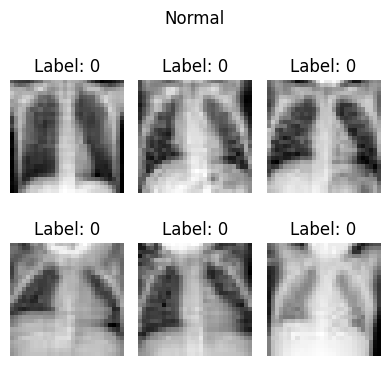

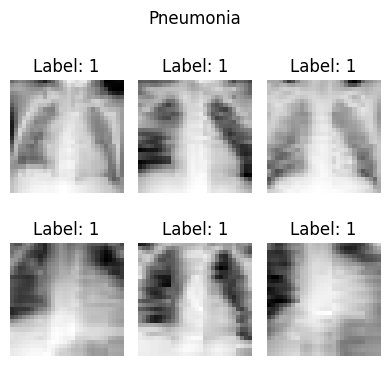

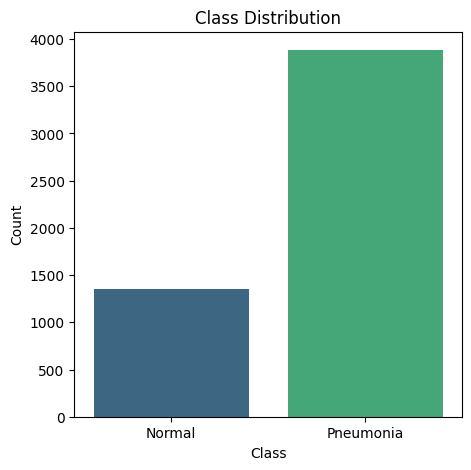

In [186]:
# Check the resolution of images
print(f'Image shape: {X[0].shape}')

# Count the number of images in each class
normal_images_count = np.sum(y == 0)
pneumonia_images_count = np.sum(y == 1)

print(f'Total normal images: {normal_images_count}')
print(f'Total pneumonia images: {pneumonia_images_count}')
print(f'Total images: {normal_images_count + pneumonia_images_count}')

# Function to display some images
def show_images(images, labels, label, title):
    plt.figure(figsize=(4,4))
    indices = np.where(labels == label)[0][:6]  # Get the first 6 indices of the specified label
    for i, idx in enumerate(indices):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.axis('off')
        plt.title(f'Label: {label}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display some normal images
show_images(X, y, 0, 'Normal')

# Display some pneumonia images
show_images(X, y, 1, 'Pneumonia')

# Distribution of classes
labels = ['Normal', 'Pneumonia']
counts = [normal_images_count, pneumonia_images_count]
data = pd.DataFrame({'Class': labels, 'Count': counts})

plt.figure(figsize=(5, 5))
sns.barplot(x='Class', y='Count', data=data, palette='viridis', hue='Class', dodge=False, legend=False)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

I randomly split the dataset into training set, validation set and test set. The training set is used to train the different models, the validation set to calculate the errors on new predictions and the test set to verify the performance of the best models on new data. The split I used is approximately: 70% training set, 15% validation set and 15% test set.

I used the function train_test_split, offered by Scikit-learn for this task, to do a first split of the data and then I did a second split of the temporary set to create all the three sets.
I used stratify to take into account the imbalance in the number of normal and pneumonia images.

In [187]:
# Division of dataset in training, validation e test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [188]:
# Normalization
X_train = X_train / 255.0
X_validation = X_validation / 255.0
X_test = X_test / 255.0

In [189]:
# Flattening the labels in 1D array
y_train = y_train.ravel()
y_validation = y_validation.ravel()
y_test = y_test.ravel()

I added a channel for the images, because the CNNs used require it.

In [190]:
# Add a channel for grayscale images
X_train = np.expand_dims(X_train, axis=-1)
X_validation = np.expand_dims(X_validation, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [191]:
print("Training set dimension:", X_train.shape)
print("Data type:", X_train.dtype)
num_samples, height, width, channels = X_train.shape
print("Number of samples:", num_samples)
print("Image height:", height)
print("Image width:", width)
print("Image number of channels:", channels)

Training set dimension: (3662, 28, 28, 1)
Data type: float64
Number of samples: 3662
Image height: 28
Image width: 28
Image number of channels: 1


I tried to apply some filters to the images, because the blur can help identifying the features.

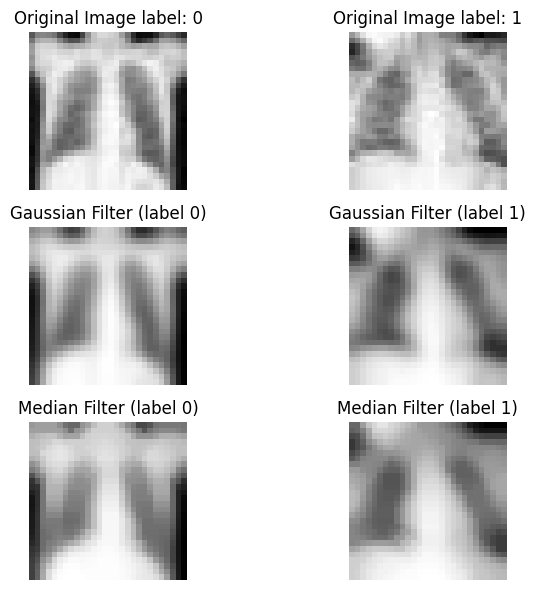

In [192]:
# Randomly select an image with label 0 (normal)
index_label_0 = random.choice(np.where(y == 0)[0])
image_label_0 = X[index_label_0]

# Randomly select an image with label 1 (pneumonia)
index_label_1 = random.choice(np.where(y == 1)[0])
image_label_1 = X[index_label_1]

# Apply Gaussian blur filter for noise reduction
blurred_image_0 = cv2.GaussianBlur(image_label_0, (5, 5), 0)
blurred_image_1 = cv2.GaussianBlur(image_label_1, (5, 5), 0)

# Apply median blur filter for noise reduction
median_filtered_image_0 = cv2.medianBlur(blurred_image_0, 5)
median_filtered_image_1 = cv2.medianBlur(blurred_image_1, 5)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(8, 6))

# First row: original images
axes[0, 0].imshow(image_label_0, cmap='gray')
axes[0, 0].set_title('Original Image label: 0')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_label_1, cmap='gray')
axes[0, 1].set_title('Original Image label: 1')
axes[0, 1].axis('off')

# Second row: images with Gaussian filter
axes[1, 0].imshow(blurred_image_0, cmap='gray')
axes[1, 0].set_title('Gaussian Filter (label 0)')
axes[1, 0].axis('off')

axes[1, 1].imshow(blurred_image_1, cmap='gray')
axes[1, 1].set_title('Gaussian Filter (label 1)')
axes[1, 1].axis('off')

# Third row: images with median filter
axes[2, 0].imshow(median_filtered_image_0, cmap='gray')
axes[2, 0].set_title('Median Filter (label 0)')
axes[2, 0].axis('off')

axes[2, 1].imshow(median_filtered_image_1, cmap='gray')
axes[2, 1].set_title('Median Filter (label 1)')
axes[2, 1].axis('off')

# Adjust the layout of the subplots to optimize spacing
plt.tight_layout()
plt.show()

# **Random Forest**

Training a Random Forest model using scikit-learn in Python. I used the technique of exhaustive parameter search via GridSearchCV to optimize the model's accuracy.
After training, I evaluated the model's performance using accuracy, confusion matrix and F1 score. Finally, I measured the processing time taken to train the model.

In [193]:
# Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # 42 is the seed
rf_param_grid = {'n_estimators': [100], 'max_depth': [None]} # 100 trees
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')

# Training Random Forest
start_time = time.time()
rf_grid_search.fit(X_train.reshape(len(X_train), -1), y_train) # Random Forest requires flattened images
end_time = time.time()

# Considering which model is the best
rf_model_best = rf_grid_search.best_estimator_
rf_pred = rf_model_best.predict(X_validation.reshape(len(X_validation), -1))
rf_accuracy = accuracy_score(y_validation, rf_pred)
rf_conf_matrix = confusion_matrix(y_validation, rf_pred)
rf_class_report = classification_report(y_validation, rf_pred)

# Predictions for the test set
rf_pred_test = rf_model_best.predict(X_test.reshape(len(X_test), -1))
rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
rf_conf_matrix_test = confusion_matrix(y_test, rf_pred_test)
rf_class_report_test = classification_report(y_test, rf_pred_test)

# Processing time
rf_processing_time = end_time - start_time

I considered some metrics to decide how this model worked.

The evaluation have been made on the validation set and on the test set to guarantee the model is not overfitting the data.
I obtained high scores for the validation set and similar scores for the test set, so I can says the model has good generalization properties.

Support indicates how many items in validation e test set effectively belong to class 0 and class 1 (15% of the total amount of instaces in the data set).

In [194]:
print("Random Forest chosen:", rf_model_best)
print("\nAccuracy Random Forest (validation):", rf_accuracy)
print("Classification Report Random Forest:")
print(rf_class_report)

print("\nAccuracy Random Forest (test):", rf_accuracy_test)
print("Classification Report Random Forest:")
print(rf_class_report_test)

Random Forest chosen: RandomForestClassifier(random_state=42)

Accuracy Random Forest (validation): 0.9477707006369427
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       202
           1       0.96      0.97      0.97       583

    accuracy                           0.95       785
   macro avg       0.94      0.92      0.93       785
weighted avg       0.95      0.95      0.95       785


Accuracy Random Forest (test): 0.9426751592356688
Classification Report Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       203
           1       0.95      0.98      0.96       582

    accuracy                           0.94       785
   macro avg       0.94      0.91      0.92       785
weighted avg       0.94      0.94      0.94       785



Here is a visual representation of the confusion matrix, which says that the most part of the images has been correctly classificated.

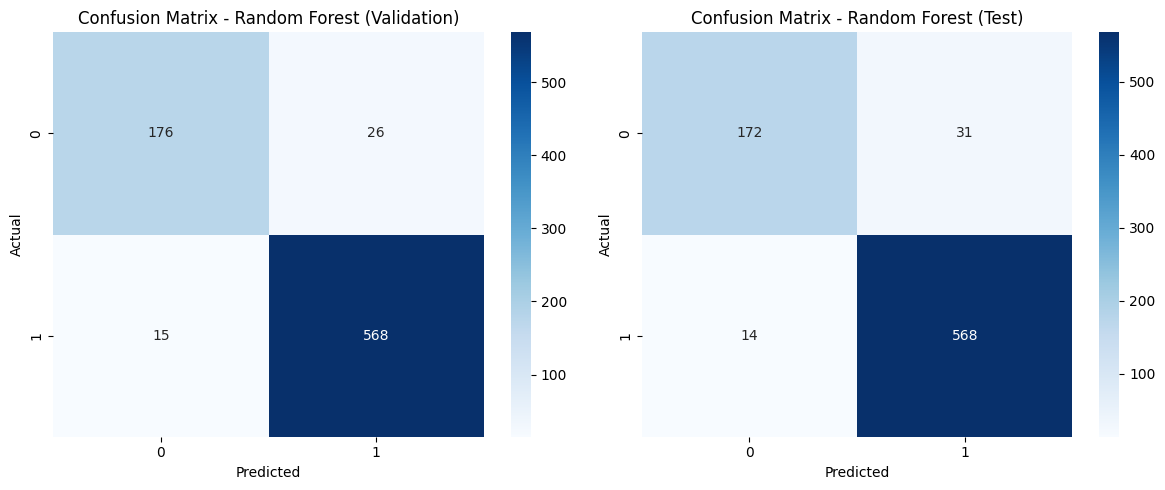

In [195]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(rf_conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(rf_conf_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Convolutional Neural Network**

The CNN model is defined using the Sequential API from Keras. It consists of convolutional layers (Conv2D) for feature extraction, followed by max pooling (MaxPooling2D) to reduce spatial dimensions. After flattening the feature maps, dense layers (Dense) with ReLU activation functions are employed for further feature processing. The output layer uses a sigmoid activation function to produce probabilities for binary classification.

In this early stopping definition, training stops if the validation loss function doesn't improve for 6 epochs and restore the weights to the values they had with the lower loss function.

In [196]:
# Definition of early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

To use F1 score as a metric during the training of my CNN model, I needed to define it as a custom metric because it's not directly available in Keras as a standard metric.

In [197]:
# Definition of f1 score
def f1_score_metric(y_true, y_pred):
    y_pred_binary = tf.round(y_pred)
    TP = tf.reduce_sum(y_true * y_pred_binary)
    FP = tf.reduce_sum((1 - y_true) * y_pred_binary)
    FN = tf.reduce_sum(y_true * (1 - y_pred_binary))

    precision = TP / (TP + FP + tf.keras.backend.epsilon())
    recall = TP / (TP + FN + tf.keras.backend.epsilon())

    f1_score = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    f1_score = tf.clip_by_value(f1_score, 0.0, 1.0)

    return f1_score


In [198]:
# CNN model
CNN_model = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])
start_time = time.time()
history_cnn = CNN_model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
end_time = time.time()


Epoch 1/100
115/115 [==============================] - 3s 11ms/step - loss: 0.4028 - accuracy: 0.8179 - f1_score_metric: 0.8896 - val_loss: 0.1881 - val_accuracy: 0.9210 - val_f1_score_metric: 0.9448
Epoch 2/100
115/115 [==============================] - 1s 8ms/step - loss: 0.1998 - accuracy: 0.9170 - f1_score_metric: 0.9434 - val_loss: 0.1712 - val_accuracy: 0.9223 - val_f1_score_metric: 0.9455
Epoch 3/100
115/115 [==============================] - 1s 7ms/step - loss: 0.1537 - accuracy: 0.9358 - f1_score_metric: 0.9532 - val_loss: 0.1365 - val_accuracy: 0.9452 - val_f1_score_metric: 0.9631
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1356 - accuracy: 0.9446 - f1_score_metric: 0.9620 - val_loss: 0.1185 - val_accuracy: 0.9503 - val_f1_score_metric: 0.9665
Epoch 5/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1182 - accuracy: 0.9522 - f1_score_metric: 0.9674 - val_loss: 0.1045 - val_accuracy: 0.9580 - val_f1_score_metric: 0.9719
Epoc

In [199]:
# validation set
y_pred_val_cnn = (CNN_model.predict(X_validation) > 0.5).astype("float32")
y_true_val_cnn = y_validation.astype("float32")

f1_score_val_cnn = f1_score_metric(y_true_val_cnn, y_pred_val_cnn)
accuracy_val_cnn = accuracy_score(y_validation, y_pred_val_cnn > 0.5)

#test set
y_pred_test_cnn = (CNN_model.predict(X_test) > 0.5).astype("float32")
y_true_test_cnn = y_test.astype("float32")

f1_score_test_cnn = f1_score_metric(y_true_test_cnn, y_pred_test_cnn)
accuracy_test_cnn = accuracy_score(y_test, y_pred_test_cnn > 0.5)

# Processing time
cnn_processing_time = end_time - start_time

25/25 [==============================] - 0s 2ms/step


Here is a representation of accuracy and loss functions through the epochs on the training set and on the validation set.

The CNN has good performaces: high values for the accuracy and low ones for the loss.

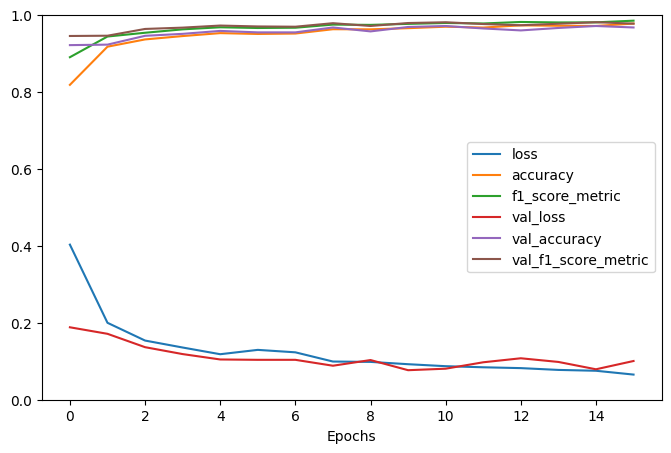

In [200]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.xlabel('Epochs')
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

These metrics assert that the CNN is working well with the data. The scores are evaluated on the validation set and are high.

In [201]:
print("CNN:\n")
print("Accuracy CNN (validation):", accuracy_val_cnn)
print(f"F1 score CNN (validation): {f1_score_val_cnn.numpy()}")

print("\nAccuracy CNN (test):", accuracy_test_cnn)
print(f"F1 score CNN (test): {f1_score_test_cnn.numpy()}")

CNN:

Accuracy CNN (validation): 0.9681528662420382
F1 score CNN (validation): 0.7420375943183899

Accuracy CNN (test): 0.954140127388535
F1 score CNN (test): 0.7477163672447205


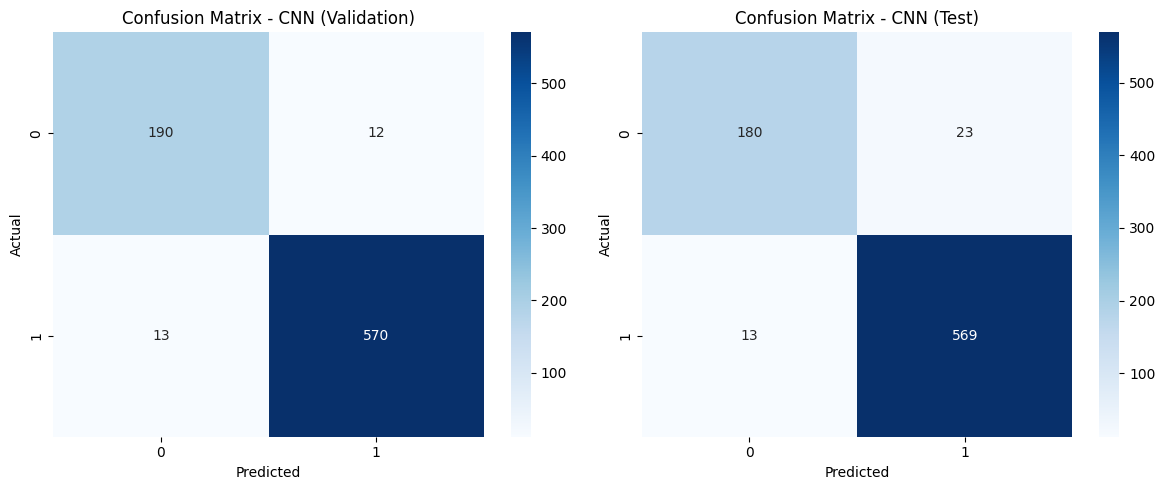

In [202]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(confusion_matrix(y_validation, y_pred_val_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [203]:
# Function to apply Gaussian filter to the images and keep the labels
def apply_gaussian_filter(X, y):
    filtered_images = []
    for image in X:
        # Apply the filter to every image
        filtered_image = cv2.GaussianBlur(image, (3, 3), 0)
        filtered_images.append(filtered_image)
    return np.array(filtered_images), np.array(y)

# Example usage
filtered_X_train, filtered_y_train = apply_gaussian_filter(X_train, y_train)
filtered_X_validation, filtered_y_validation = apply_gaussian_filter(X_validation, y_validation)
filtered_X_test, filtered_y_test = apply_gaussian_filter(X_test, y_test)

In [204]:
# CNN model
model = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])
start_time = time.time()

# Training the model with filtered data
history = model.fit(filtered_X_train, filtered_y_train, epochs=100, validation_data=(filtered_X_validation, filtered_y_validation), callbacks=[early_stopping])

end_time = time.time()

Epoch 1/100
115/115 [==============================] - 2s 7ms/step - loss: 0.4196 - accuracy: 0.8086 - f1_score_metric: 0.8807 - val_loss: 0.2174 - val_accuracy: 0.9057 - val_f1_score_metric: 0.9337
Epoch 2/100
115/115 [==============================] - 1s 5ms/step - loss: 0.2027 - accuracy: 0.9164 - f1_score_metric: 0.9430 - val_loss: 0.1831 - val_accuracy: 0.9223 - val_f1_score_metric: 0.9464
Epoch 3/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1527 - accuracy: 0.9380 - f1_score_metric: 0.9556 - val_loss: 0.1270 - val_accuracy: 0.9478 - val_f1_score_metric: 0.9637
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.1336 - accuracy: 0.9454 - f1_score_metric: 0.9626 - val_loss: 0.1299 - val_accuracy: 0.9401 - val_f1_score_metric: 0.9590
Epoch 5/100
115/115 [==============================] - 1s 7ms/step - loss: 0.1207 - accuracy: 0.9569 - f1_score_metric: 0.9704 - val_loss: 0.1112 - val_accuracy: 0.9541 - val_f1_score_metric: 0.9690
Epoch

In [205]:
filtered_y_pred_val_cnn = (model.predict(filtered_X_validation) > 0.5).astype("float32")  # Ensure predictions are float32
y_true_val_cnn = filtered_y_validation.astype("float32")  # Ensure labels are float32

filtered_y_pred_test_cnn = (model.predict(filtered_X_test) > 0.5).astype("float32")  # Ensure predictions are float32
y_true_test_cnn = filtered_y_test.astype("float32")  # Ensure labels are float32

# Calculate accuracy and f1 score
filtered_accuracy_val_cnn = accuracy_score(y_true_val_cnn, (filtered_y_pred_val_cnn > 0.5).astype("int32"))
filtered_f1_score_val_cnn = f1_score_metric(y_true_val_cnn, filtered_y_pred_val_cnn)

filtered_accuracy_test_cnn = accuracy_score(y_true_test_cnn, (filtered_y_pred_test_cnn > 0.5).astype("int32"))
filtered_f1_score_test_cnn = f1_score_metric(y_true_test_cnn, filtered_y_pred_test_cnn)


25/25 [==============================] - 0s 2ms/step


I compared the results obtained without and with filter using CNN, but there are not significant improvements, so I decided to continue with the orginal images.

In [206]:
# Without filter
print("CNN without filter:")
print("Accuracy CNN (validation):", accuracy_val_cnn)
print("Accuracy CNN (test):", accuracy_test_cnn)
print(f"F1 score CNN (validation): {f1_score_val_cnn.numpy()}")
print(f"F1 score CNN (test): {f1_score_test_cnn.numpy()}")

# With filter
print("\nCNN with filter:")
print("Accuracy CNN (validation):", filtered_accuracy_val_cnn)
print("Accuracy CNN (test):", filtered_accuracy_test_cnn)
print(f"F1 score CNN (validation): {filtered_f1_score_val_cnn.numpy()}")
print(f"F1 score CNN (test): {filtered_f1_score_test_cnn.numpy()}")

CNN without filter:
Accuracy CNN (validation): 0.9681528662420382
Accuracy CNN (test): 0.954140127388535
F1 score CNN (validation): 0.7420375943183899
F1 score CNN (test): 0.7477163672447205

CNN with filter:
Accuracy CNN (validation): 0.9732484076433121
Accuracy CNN (test): 0.9605095541401274
F1 score CNN (validation): 0.7433115243911743
F1 score CNN (test): 0.745833158493042


# Regularization

I decided to add some reguarization and retrain the model to have some improvements on the classification. I chose a L2 penalty.

In [207]:
# Adding some regularizers to the CNN
CNN_model_reg = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(84, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Re-training the model
CNN_model_reg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])
history_reg = CNN_model_reg.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation), callbacks=[early_stopping])
#cnn_accuracy = CNN_model_reg.evaluate(X_test, y_test)[1]


Epoch 1/100
115/115 [==============================] - 4s 10ms/step - loss: 1.5769 - accuracy: 0.7941 - f1_score_metric: 0.8711 - val_loss: 0.6196 - val_accuracy: 0.8968 - val_f1_score_metric: 0.9247
Epoch 2/100
115/115 [==============================] - 1s 8ms/step - loss: 0.4587 - accuracy: 0.9184 - f1_score_metric: 0.9445 - val_loss: 0.3806 - val_accuracy: 0.9236 - val_f1_score_metric: 0.9459
Epoch 3/100
115/115 [==============================] - 1s 7ms/step - loss: 0.3407 - accuracy: 0.9249 - f1_score_metric: 0.9466 - val_loss: 0.3040 - val_accuracy: 0.9312 - val_f1_score_metric: 0.9522
Epoch 4/100
115/115 [==============================] - 1s 5ms/step - loss: 0.3218 - accuracy: 0.9249 - f1_score_metric: 0.9487 - val_loss: 0.2786 - val_accuracy: 0.9287 - val_f1_score_metric: 0.9499
Epoch 5/100
115/115 [==============================] - 1s 6ms/step - loss: 0.2603 - accuracy: 0.9418 - f1_score_metric: 0.9597 - val_loss: 0.2469 - val_accuracy: 0.9363 - val_f1_score_metric: 0.9561
Epoc

In [208]:
# Calculate accuracy and f1 score for validation set
y_pred_val_cnn_reg = (CNN_model_reg.predict(X_validation) > 0.5).astype("int32")
accuracy_val_cnn_reg = accuracy_score(y_validation, y_pred_val_cnn_reg)
f1_score_val_cnn_reg = f1_score_metric(y_validation, CNN_model_reg.predict(X_validation))

# Calculate accuracy and f1 score for test set
y_pred_test_cnn_reg = (CNN_model_reg.predict(X_test) > 0.5).astype("int32")
accuracy_test_cnn_reg = accuracy_score(y_test, y_pred_test_cnn_reg)
f1_score_test_cnn_reg = f1_score_metric(y_test, CNN_model_reg.predict(X_test))

25/25 [==============================] - 0s 3ms/step


In [209]:
# accuracy
print("CNN with regularization")
print("Accuracy CNN (validation):", accuracy_val_cnn_reg)
print("Accuracy CNN (test):", accuracy_test_cnn_reg)
print(f"F1 score CNN (validation): {f1_score_val_cnn_reg.numpy()}")
print(f"F1 score CNN (test): {f1_score_test_cnn_reg.numpy()}")

CNN with regularization
Accuracy CNN (validation): 0.9490445859872612
Accuracy CNN (test): 0.9503184713375796
F1 score CNN (validation): 0.7464772462844849
F1 score CNN (test): 0.7495900392532349


Looking at the graphic I can see that an improvement has been made. The loss function reaches lower values than before and the two functions for training and validation sets are one the same level after the first epoch.

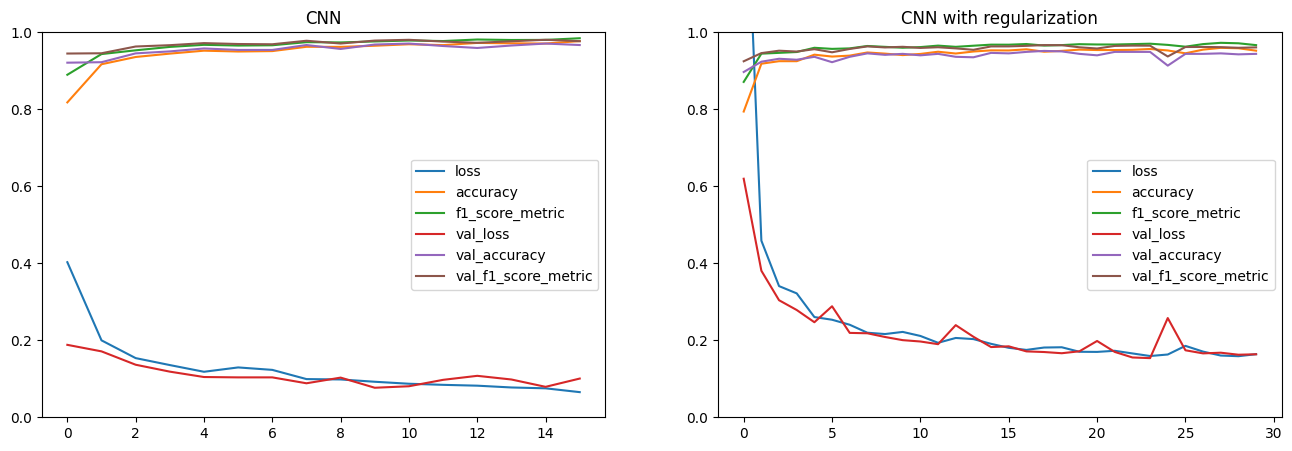

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

pd.DataFrame(history_cnn.history).plot(ax=axes[0])
axes[0].set_ylim(0, 1)
axes[0].set_title('CNN')

pd.DataFrame(history_reg.history).plot(ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('CNN with regularization')

plt.show()

The confusion matrix of the regularized predictions says that the misclassified images are less than before, when I used a CNN without L2 Penalty.

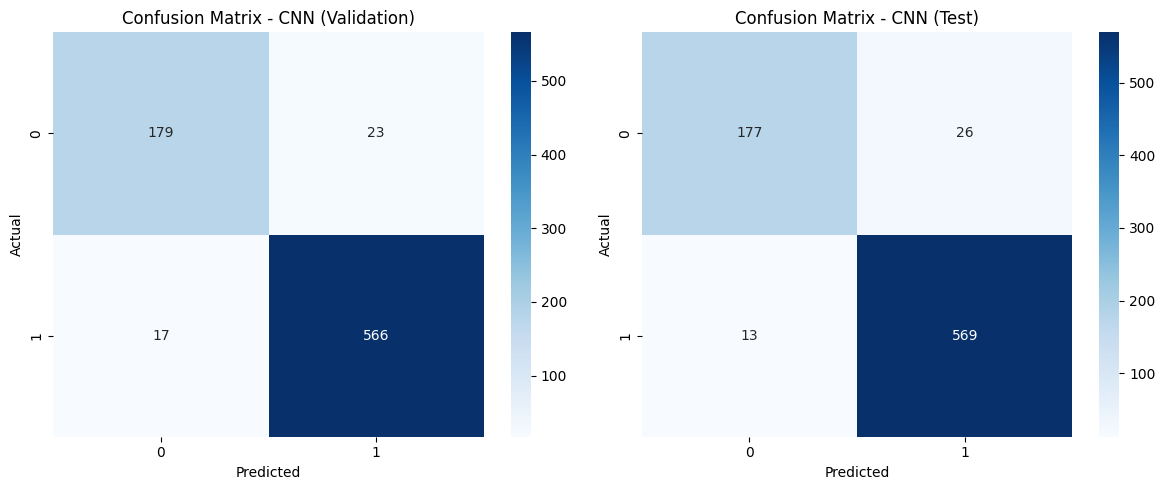

In [211]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(confusion_matrix(y_validation, y_pred_val_cnn_reg), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn_reg), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Data augmentation

In [212]:
X_train_expand = np.expand_dims(filtered_X_train, axis=-1)
X_val_expand = np.expand_dims(filtered_X_validation, axis=-1)
X_test_expand = np.expand_dims(filtered_X_test, axis=-1)

In [213]:
# Define data augmentation pipeline using Keras Sequential API
train_datagen = ImageDataGenerator(
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,  # no horizontal flip for medical images
)

# Defining validation set
val_datagen = ImageDataGenerator()

# Making sure the changes fit the data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_validation, y_validation, batch_size=32)

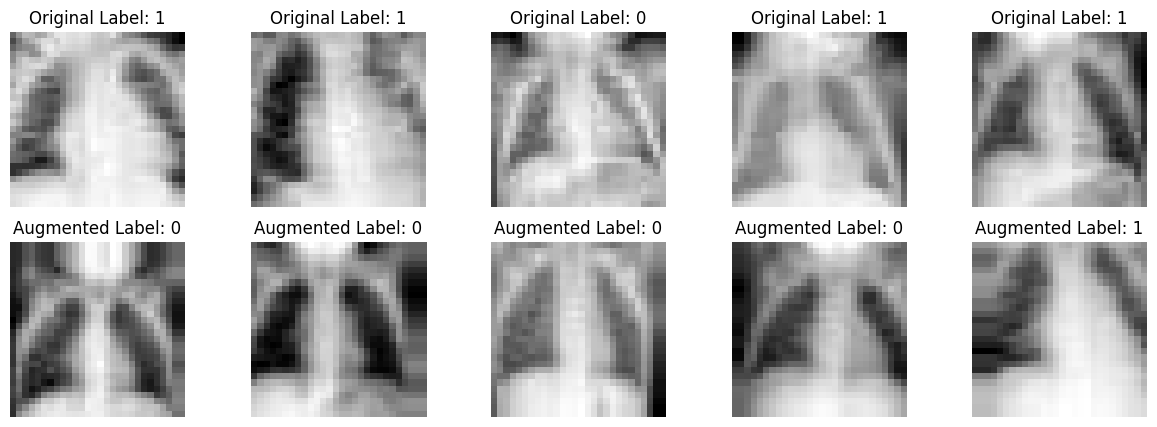

In [214]:
# Display some of the orginal images
num_images_to_display = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    # Selection of random images
    index = np.random.randint(0, len(X_train))
    original_image = X_train[index]
    original_label = y_train[index]

    # Display original image with label
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Label: {original_label}")
    plt.axis('off')

# Display some generated images
for i in range(num_images_to_display):
    augmented_data = next(train_generator)
    augmented_image = augmented_data[0][0]  # generated image
    augmented_label = augmented_data[1][0]  # generated label

    # Display generated image with label
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Label: {augmented_label}")
    plt.axis('off')

plt.show()

In [215]:
CNN_augmentation = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(84, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])

In [216]:
# Compile the model
CNN_augmentation.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Example training with data augmentation and early stopping
epochs = 100
batch_size = 32

# Train the model with early stopping
history_aug = CNN_augmentation.fit(train_generator, epochs=epochs,
                            validation_data=(X_validation, y_validation),
                            callbacks=[early_stopping])

Epoch 1/100
115/115 [==============================] - 3s 15ms/step - loss: 1.6271 - accuracy: 0.7378 - f1_score_metric: 0.8420 - val_loss: 0.7414 - val_accuracy: 0.7452 - val_f1_score_metric: 0.8520
Epoch 2/100
115/115 [==============================] - 1s 13ms/step - loss: 0.5815 - accuracy: 0.8102 - f1_score_metric: 0.8806 - val_loss: 0.4141 - val_accuracy: 0.8815 - val_f1_score_metric: 0.9221
Epoch 3/100
115/115 [==============================] - 2s 13ms/step - loss: 0.4318 - accuracy: 0.8654 - f1_score_metric: 0.9093 - val_loss: 0.4087 - val_accuracy: 0.8841 - val_f1_score_metric: 0.9173
Epoch 4/100
115/115 [==============================] - 2s 13ms/step - loss: 0.3906 - accuracy: 0.8801 - f1_score_metric: 0.9192 - val_loss: 0.3620 - val_accuracy: 0.8955 - val_f1_score_metric: 0.9257
Epoch 5/100
115/115 [==============================] - 2s 19ms/step - loss: 0.3737 - accuracy: 0.8826 - f1_score_metric: 0.9206 - val_loss: 0.3343 - val_accuracy: 0.9083 - val_f1_score_metric: 0.9363


In [217]:
# Predictions on validation set
y_pred_val_cnn_aug = (CNN_augmentation.predict(X_val_expand) > 0.5).astype("int32")
accuracy_val_cnn_aug = accuracy_score(y_validation, y_pred_val_cnn_aug)
f1_score_val_cnn_aug = f1_score_metric(y_validation, CNN_augmentation.predict(X_val_expand))

# Predictions on test set
y_pred_test_cnn_aug = (CNN_augmentation.predict(X_test_expand) > 0.5).astype("int32")
accuracy_test_cnn_aug = accuracy_score(y_test, y_pred_test_cnn_aug)
f1_score_test_cnn_aug = f1_score_metric(y_test, CNN_augmentation.predict(X_test_expand))


25/25 [==============================] - 0s 2ms/step


I obtained a little improvement on the accuracy and on the f1 score.

In [218]:
print("CNN with regularization")
print("Accuracy CNN (validation):", accuracy_val_cnn_reg)
print("Accuracy CNN (test):", accuracy_test_cnn_reg)
print(f"F1 score CNN (validation): {f1_score_val_cnn_reg.numpy()}")
print(f"F1 score CNN (test): {f1_score_test_cnn_reg.numpy()}")

print("\nCNN with regularization and data augmentation")
print("Accuracy CNN (validation):", accuracy_val_cnn_aug)
print("Accuracy CNN (test):", accuracy_test_cnn_aug)
print(f"F1 score CNN (validation): {f1_score_val_cnn_aug.numpy()}")
print(f"F1 score CNN (test): {f1_score_test_cnn_aug.numpy()}")

CNN with regularization
Accuracy CNN (validation): 0.9490445859872612
Accuracy CNN (test): 0.9503184713375796
F1 score CNN (validation): 0.7464772462844849
F1 score CNN (test): 0.7495900392532349

CNN with regularization and data augmentation
Accuracy CNN (validation): 0.9337579617834395
Accuracy CNN (test): 0.9159235668789809
F1 score CNN (validation): 0.7708624005317688
F1 score CNN (test): 0.773105800151825


The curves are more stable than before, signaling that the overfitting has been reduced.

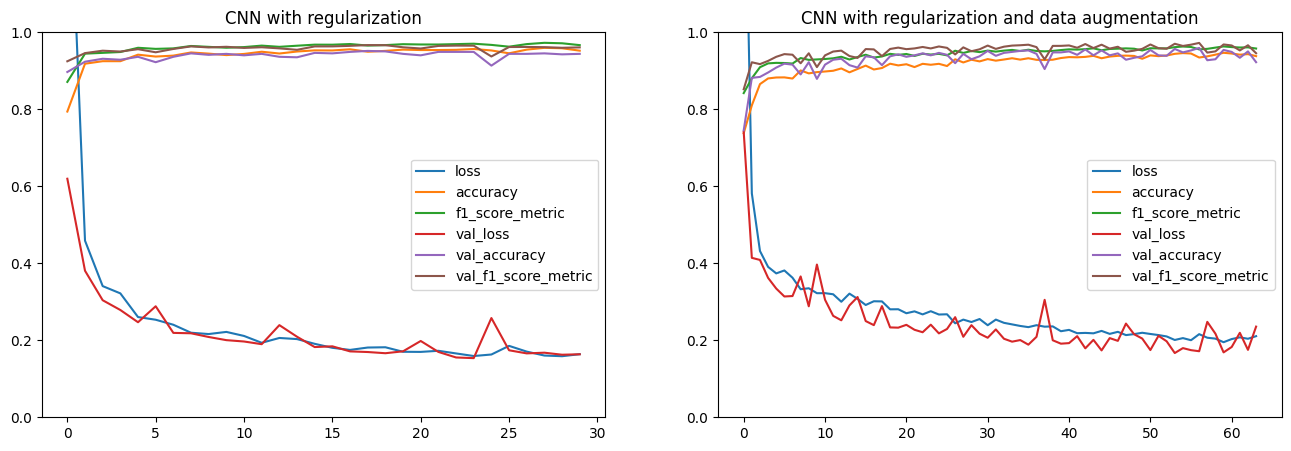

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

pd.DataFrame(history_reg.history).plot(ax=axes[0])
axes[0].set_ylim(0, 1)
axes[0].set_title('CNN with regularization')

pd.DataFrame(history_aug.history).plot(ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('CNN with regularization and data augmentation')

plt.show()

In [220]:
from keras.initializers import he_normal

CNN_tune = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=regularizers.l2(0.01), kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), kernel_initializer=he_normal()),
    Dense(1, activation='sigmoid')
])

# Compile the model
CNN_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_metric])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

CNN_tune.summary()

history_tune = CNN_tune.fit(
    train_generator,
    steps_per_epoch=len(X_train_expand) // 32,
    epochs=120,
    validation_data=val_generator,
    validation_steps=len(X_val_expand) // 32,
    callbacks=([early_stopping],[reduce_lr])
)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_8 (Bat  (None, 28, 28, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_9 (Bat  (None, 14, 14, 16)        64        
 chNormalization)                                                
                                                     

In [221]:
# Predictions on validation set
y_pred_val_cnn_tune = (CNN_tune.predict(X_val_expand) > 0.5).astype("int32")
accuracy_val_cnn_tune = accuracy_score(y_validation, y_pred_val_cnn_tune)
f1_score_val_cnn_tune = f1_score_metric(y_validation, CNN_tune.predict(X_val_expand))

# Predictions on test set
y_pred_test_cnn_tune = (CNN_tune.predict(X_test_expand) > 0.5).astype("int32")
accuracy_test_cnn_tune = accuracy_score(y_test, y_pred_test_cnn_tune)
f1_score_test_cnn_tune = f1_score_metric(y_test, CNN_tune.predict(X_test_expand))

25/25 [==============================] - 0s 3ms/step


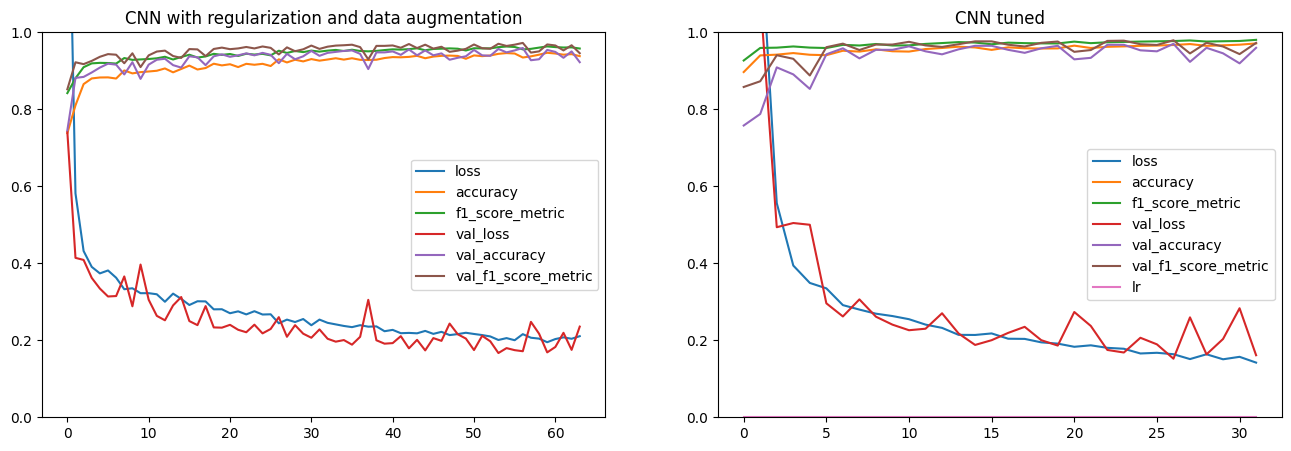

In [222]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

pd.DataFrame(history_aug.history).plot(ax=axes[0])
axes[0].set_ylim(0, 1)
axes[0].set_title('CNN with regularization and data augmentation')

pd.DataFrame(history_tune.history).plot(ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('CNN tuned')

plt.show()

In [223]:
print("CNN with regularization and data augmentation")
print("Accuracy CNN (validation):", accuracy_val_cnn_aug)
print("Accuracy CNN (test):", accuracy_test_cnn_aug)
print(f"F1 score CNN (validation): {f1_score_val_cnn_aug.numpy()}")
print(f"F1 score CNN (test): {f1_score_test_cnn_aug.numpy()}")

print("\nCNN tuned")
print("Accuracy CNN (validation):", accuracy_val_cnn_tune)
print("Accuracy CNN (test):", accuracy_test_cnn_tune)
print(f"F1 score CNN (validation): {f1_score_val_cnn_tune.numpy()}")
print(f"F1 score CNN (test): {f1_score_test_cnn_tune.numpy()}")

CNN with regularization and data augmentation
Accuracy CNN (validation): 0.9337579617834395
Accuracy CNN (test): 0.9159235668789809
F1 score CNN (validation): 0.7708624005317688
F1 score CNN (test): 0.773105800151825

CNN tuned
Accuracy CNN (validation): 0.954140127388535
Accuracy CNN (test): 0.9439490445859873
F1 score CNN (validation): 0.7613040804862976
F1 score CNN (test): 0.7575998902320862


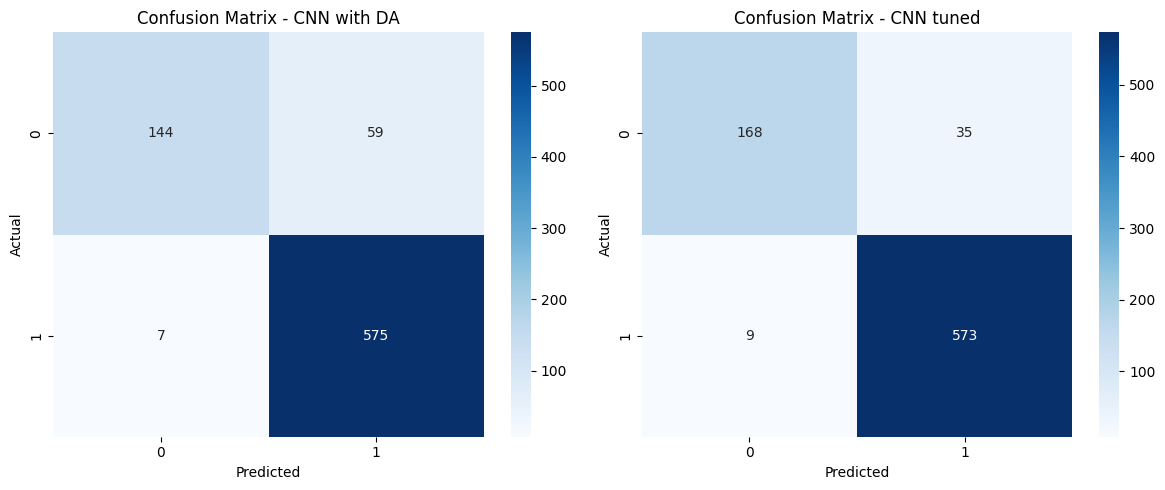

In [224]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn_aug), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN with DA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn_tune), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Logistic regression**

As logistic regression works with 1D data, flatten the features into a single vector for each data point.

In [225]:
# Reshape every image in X_train to use it in Logistic Regression Model
X_train_flat = np.array([image.reshape(-1) for image in X_train])

# Reshape every image in X_validation
X_validation_flat = np.array([image.reshape(-1) for image in X_validation])

# Reshape every image in X_test
X_test_flat = np.array([image.reshape(-1) for image in X_test])

# Create a StandardScaler object and fit it to the training data
scaler = RobustScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_flat)

# Fit the scaler to the validation set
X_validation_scaled = scaler.transform(X_validation_flat)

# Transform the testing data using the same scaler
X_test_scaled = scaler.transform(X_test_flat)

# Reshape y into a 1D array using reshape(-1)
y_train_1d = tf.reshape(y_train, [-1])  # Reshape y_train to 1D tensor
y_validation_1d = tf.reshape(y_validation, [-1])  # Reshape y_validation to 1D tensor
y_test_1d = tf.reshape(y_test, [-1])  # Reshape y_test to 1D tensor

# Verify data are scaled correctly
mean = X_train_scaled[0].mean(axis=0)
print(mean)

std = X_train_scaled[0].std(axis=0)
print(std)

print(y_train_1d)
print(y_test_1d[1:10], '...', y_test_1d[-10:])

-0.0801862001179957
0.8398946787119398
tf.Tensor([0 1 1 ... 1 1 0], shape=(3662,), dtype=uint8)
tf.Tensor([1 1 0 1 0 1 1 1 1], shape=(9,), dtype=uint8) ... tf.Tensor([0 1 1 1 1 1 1 1 0 1], shape=(10,), dtype=uint8)


In [233]:
# Create a logistic regression model
log_reg = LogisticRegression(solver='newton-cg')  # Newton's method for optimization. It's suitable for small to medium-sized datasets.

# Train the model on the training data
log_reg.fit(X_train_scaled, y_train_1d)

# Make predictions on the testing data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
accuracy_val_log_reg = accuracy_score(y_validation_1d, log_reg.predict(X_validation_scaled))
# Compute F1 score using f1_score_metric
f1_score_val_log_reg = f1_score_metric(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
conf_matrix_val_log_reg = confusion_matrix(y_validation_1d, log_reg.predict(X_validation_scaled))
class_report_val_log_reg = classification_report(y_validation_1d, log_reg.predict(X_validation_scaled))

accuracy_log_reg = accuracy_score(y_test_1d, y_pred)
f1_score_log_reg = f1_score_metric(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
conf_matrix = confusion_matrix(y_test_1d, y_pred)
class_report = classification_report(y_test_1d, y_pred)

# Print the evaluation results
print("Accuracy on validation set:", accuracy_val_log_reg)
print("Accuracy on test set:", accuracy_log_reg)

Accuracy on validation set: 0.9554140127388535
Accuracy on test set: 0.9490445859872612


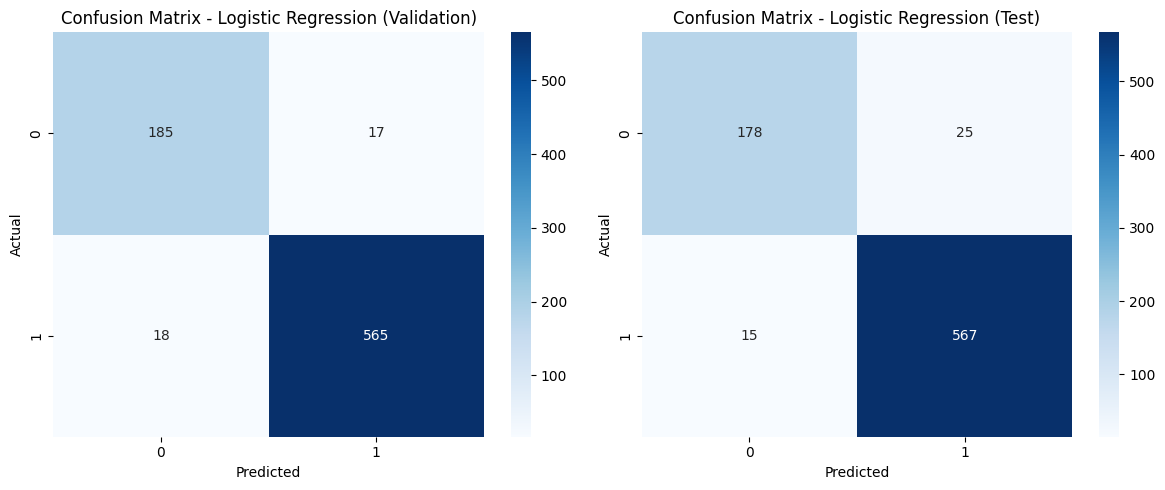

In [227]:
# Create a figure with a specified size
plt.figure(figsize=(12, 5))

# Create the first subplot in a 1x2 grid
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
sns.heatmap(conf_matrix_val_log_reg, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Create the second subplot in the same 1x2 grid
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **Model comparison**
I plotted the accuracy for the previous models. The highest values is the CNN one, even if all models have an accuracy over 90%.

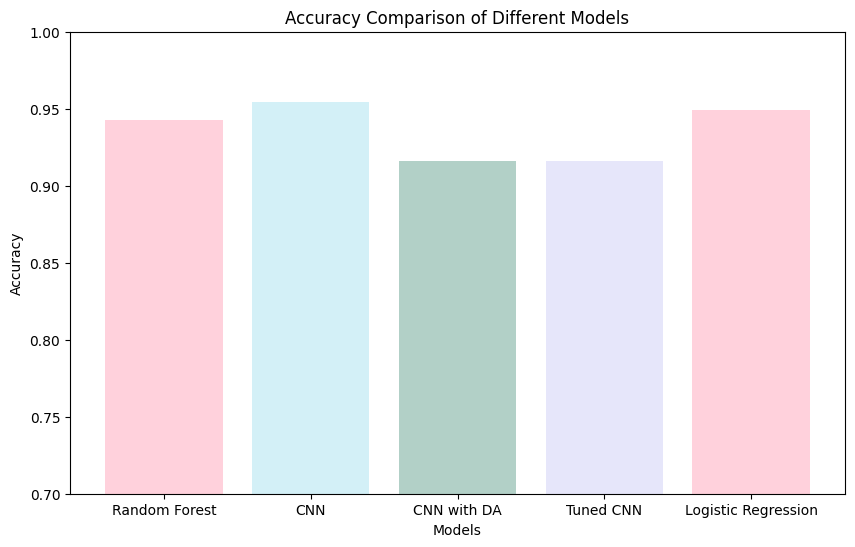

In [228]:
# Accuracy scores for each model
models = ['Random Forest', 'CNN', 'CNN with DA', 'Tuned CNN', 'Logistic Regression']
accuracy_scores = [rf_accuracy_test, accuracy_test_cnn, accuracy_test_cnn_aug, accuracy_test_cnn_aug, accuracy_log_reg]  # Example accuracy scores

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy_scores, color = ["#ffd1dc", "#d3f0f7", "#b2d0c7", "#e6e6fa"])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0.7, 1)
plt.show()

In [229]:
# Create a dictionary to store predicted probabilities for each model
predicted_probs = {
    'Random Forest': rf_model_best.predict_proba(X_test_scaled)[:, 1],
    'CNN': CNN_model.predict(X_test),
    'CNN with DA': CNN_augmentation.predict(X_test),
    'Tuned CNN': CNN_tune.predict(X_test),
    'Logistic Regression': log_reg.predict_proba(X_test_scaled)[:, 1]
}

25/25 [==============================] - 0s 3ms/step


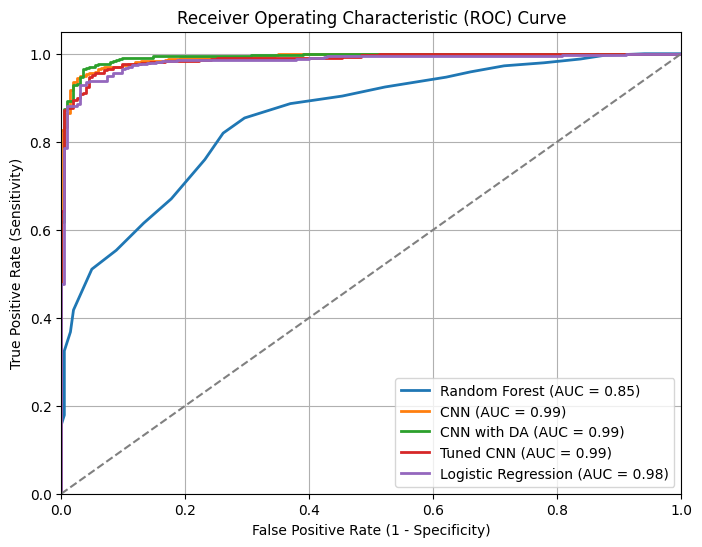

In [230]:
model_predictions = {
    'Random Forest': (predicted_probs['Random Forest'], y_test),
    'CNN': (predicted_probs['CNN'], y_test),
    'CNN with DA': (predicted_probs['Tuned CNN'], y_test),
    'Tuned CNN': (predicted_probs['CNN with DA'], y_test),
    'Logistic Regression': (predicted_probs['Logistic Regression'], y_test)
}

# Plot ROC curve for each model
plt.figure(figsize=(8, 6))
for model_name, (predicted_probs, y_test) in model_predictions.items():
    if isinstance(predicted_probs, tuple):  # If predicted_probs is a tuple
        predicted_probs = predicted_probs[0]  # Get the first element of the tuple
    if predicted_probs.ndim == 1:  # If predicted_probs is a 1D array (binary classification)
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    else:  # If predicted_probs is a 2D array (multiclass classification)
        # Assuming we have binary classification for each class vs the rest
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(predicted_probs.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test, predicted_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2, label=f'{model_name} (AUC = {roc_auc[i]:.2f})')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**ROC Curve Analysis**

ROC curves assessed model performance (Random Forest, CNN, KNN, Logistic Regression). The CNN achieved the highest AUC, indicating better differentiation between normal and pneumonia cases in the MedMNIST dataset. Logistic Regression works nearly as good ad the CNN. KNN and Random Forest showed more room for improvement as their curves approached the random classifier line.

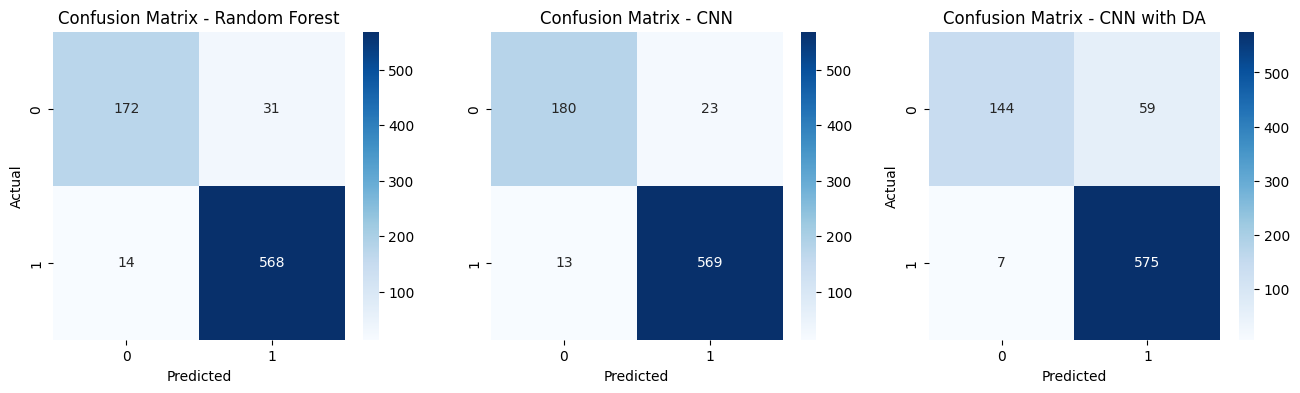

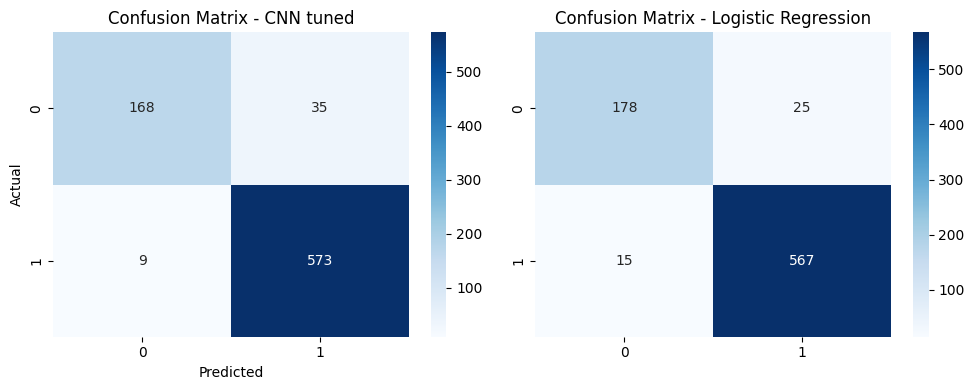

In [231]:
# Create a figure with a specified size
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, rf_pred_test), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn_aug), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN with DA')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_test_cnn_tune), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - CNN tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, log_reg.predict(X_test_scaled)), annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **F1-score**
F1-score is particularly useful for imbalanced datasets, where there might be a significant difference in the number of positive and negative examples. This is the case of MedMNIST Pneumonia data set, in which we have more pneumonia images than normal ones, as showed at the beginning.

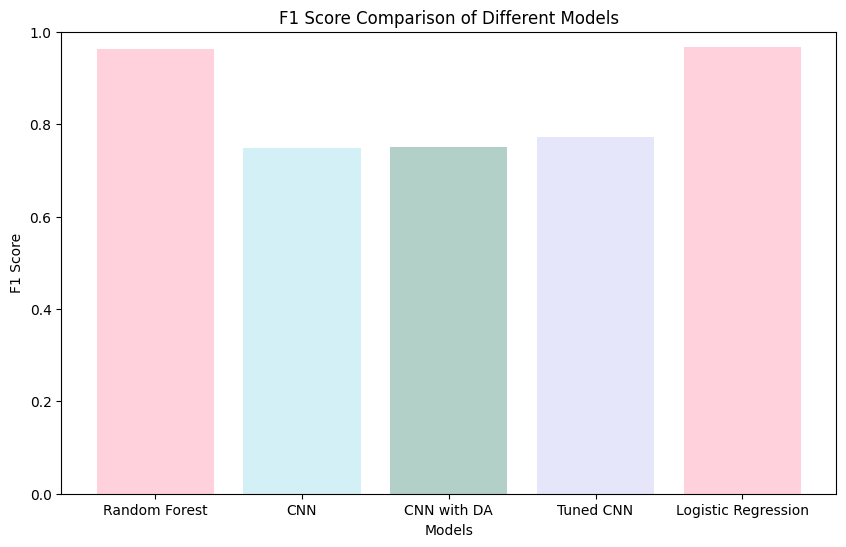

In [234]:
# F1 scores for each model
f1_score_rf = f1_score_metric(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred_rf, dtype=tf.float32))

f1_scores = [f1_score_rf, f1_score_test_cnn, f1_score_test_cnn_reg, f1_score_test_cnn_aug, f1_score_log_reg]  # Example F1 scores

# Create a bar plot for F1 scores
plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores, color=["#ffd1dc", "#d3f0f7", "#b2d0c7", "#e6e6fa"])
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison of Different Models')
plt.ylim(0, 1)
plt.show()


Using F1 score, I can assert that the best models are Random Forest and Logistic Regression.